In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
from scipy import sparse
from tqdm import tqdm, tqdm_notebook

%run ../Scripts/mutation.py
%run ../Scripts/initMethods.py
%run ../Scripts/formulas.py
%run ../Scripts/entropy.py

In [25]:
params = { #parameters relevant for the equations
    "Nh":           10000,
    "N0":          100000,
    "M":                1, #Also L, total number of spacers
    "mu":               1, #mutation rate
    "gamma_shape":     20, 
}
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
    "xdomain":                    100,
    "dx":                           1,
    "dt":                           1,
    "initial_mean_n":           [0,0],
    "initial_var_n":               10,
    "num_threads":                  1,
}

In [7]:
from mutation import mutation as mutation2
n = init_guassian(params["N0"], sim_params, "n")
n_new = mutation2(n, params, sim_params)
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
xspace = np.arange(-xdomain, xdomain, dx )

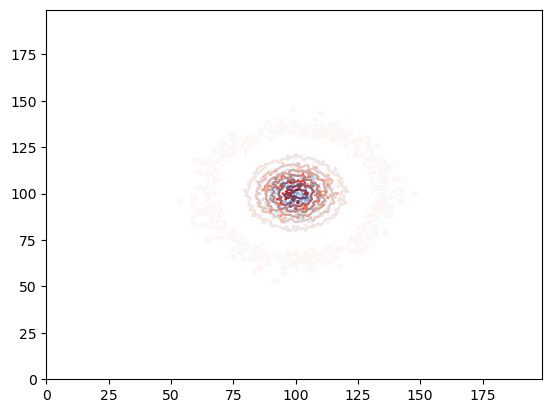

In [8]:
plt.contour(n.todense(), cmap = "Reds")
plt.contour(n_new.todense(), cmap = "Blues", alpha = 0.5)

In [20]:
def entropy_simulation2(params, sim_params, t = 20, to_plot = False):
    n_old = init_guassian(params["N0"], sim_params, "n")
    n_new = mutation(n_old, params, sim_params)
    xdomain = sim_params["xdomain"]
    dx = sim_params["dx"]
    xspace = np.arange(-xdomain, xdomain, dx )
    
    entropy_change = np.zeros(t)
    entropy = np.zeros(t)
    entropy_guassian = np.zeros(t)

    N = params["N0"]
    if to_plot:
        plt.figure()

    for i in range(1, t):
        func = params["N0"]*guassian_diffusion(xspace, xspace, i, params, sim_params)
        flat_func = np.sum(func, axis = 0)

        n_new = mutation(n_old, params, sim_params)
        flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

        if i%5 ==0 and to_plot:
            plt.plot(xspace, flat_func, alpha = 0.3)
            plt.plot(xspace, flat_n_new, label = f"time = {i}")

        entropy[i] = compute_entropy(n_new)
        entropy_change[i] = compute_entropy_change(n_new, n_old)
        entropy_guassian[i] = compute_entropy(func)
        n_old = n_new
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

    if to_plot:
        plt.legend()
        plt.show()
    return entropy_change, entropy, entropy_guassian, flat_n_new

In [33]:
diff_consts = []
entropies = []
n_news = []
params["gamma_shape"] = 20
sim_params["xdomain"] = 1000
n_old = init_guassian(params["N0"], sim_params, "n")

for mu in [0.01, 0.05, 0.1 , 0.5, 1]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal, n_new = entropy_simulation2(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])
    n_news.append(n_new)


(-274.95, 273.95, -203.75, 4278.75)

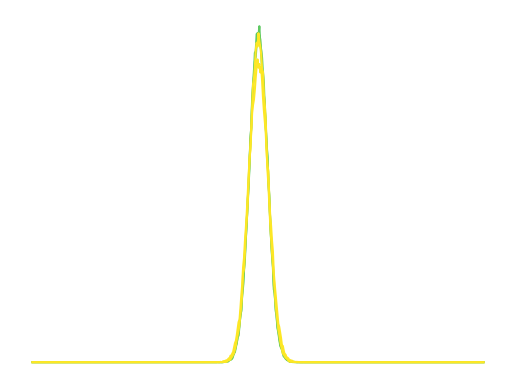

In [41]:
xdomain = sim_params["xdomain"]
dx = sim_params["dx"]
xspace = np.arange(-xdomain, xdomain, dx )
mu_list = [0.01, 0.1, 1, 5]
colors = []
    # plt.plot(xspace, flat_n, label = "original dist")
for n_new, mu in zip(n_news, mu_list):
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    color = plt.cm.viridis(mu/4 +0.75)
    colors.append(color)
    plt.plot(xspace[750:1250], flat_n_new[750:1250], color = color)

plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('off')
# plt.colorbar()

In [42]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]
diff_const = calc_diff_const(params, sim_params)

for var, entropy_change in zip(variances, entropies):
    plt.plot(t_range, entropy_change[1:], label = f"var = {var}",linestyle = "dotted", linewidth = 1.5)
    plt.plot(t_range, N*entropy_production_mutation(var**2, diff_const,t_range))
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.legend()
plt.show()

NameError: name 'variances' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
diff_consts = []
entropies = []
params["gamma_shape"] = 0.3
sim_params["xdomain"] = 1000

for mu in [1, 10, 50, 100]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,t = 10, to_plot = False)
    entropies.append([entropy, entropy_normal])

In [ ]:
plt.figure(figsize = [5, 5])
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2500, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

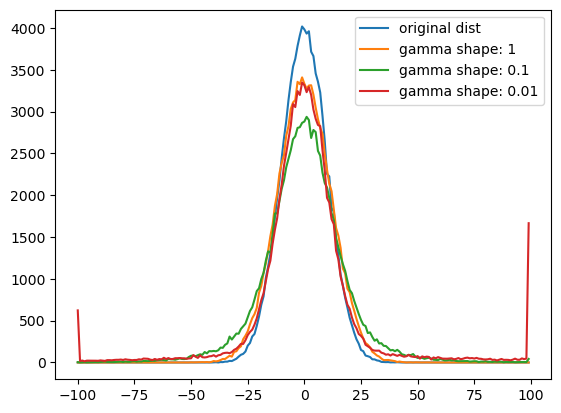

In [8]:
n = init_guassian(params["N0"], sim_params, "n")
params["mu"] = 10

flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
plt.plot(xspace, flat_n, label = "original dist")
for i in [1, 1/10, 1/100]:
    params["gamma_shape"] = i
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=f"gamma shape: {i}")
plt.legend()

In [30]:
%run ../Scripts/entropy.py

params["mu"] = mu = 10
params["gamma_shape"]= 0.5

In [17]:
def entropy_simulation(params, sim_params, t = 20, to_plot = False):
    n_old = init_guassian(params["N0"], sim_params, "n")
    n_new = mutation(n_old, params, sim_params)
    xdomain = sim_params["xdomain"]
    dx = sim_params["dx"]
    xspace = np.arange(-xdomain, xdomain, dx )
    
    entropy_change = np.zeros(t)
    entropy = np.zeros(t)
    entropy_guassian = np.zeros(t)

    N = params["N0"]
    if to_plot:
        plt.figure()

    for i in range(1, t):
        func = params["N0"]*guassian_diffusion(xspace, xspace, i, params, sim_params)
        flat_func = np.sum(func, axis = 0)

        n_new = mutation(n_old, params, sim_params)
        flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()

        if i%5 ==0 and to_plot:
            plt.plot(xspace, flat_func, alpha = 0.3)
            plt.plot(xspace, flat_n_new, label = f"time = {i}")

        entropy[i] = compute_entropy(n_new)
        entropy_change[i] = compute_entropy_change(n_new, n_old)
        entropy_guassian[i] = compute_entropy(func)
        n_old = n_new

    if to_plot:
        plt.legend()
        plt.show()
    return entropy_change, entropy, entropy_guassian

In [26]:
diff_consts = []
entropies = []
params["gamma_shape"] = 20
sim_params["xdomain"] = 1000

for mu in [0.01, 0.1 , 1]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

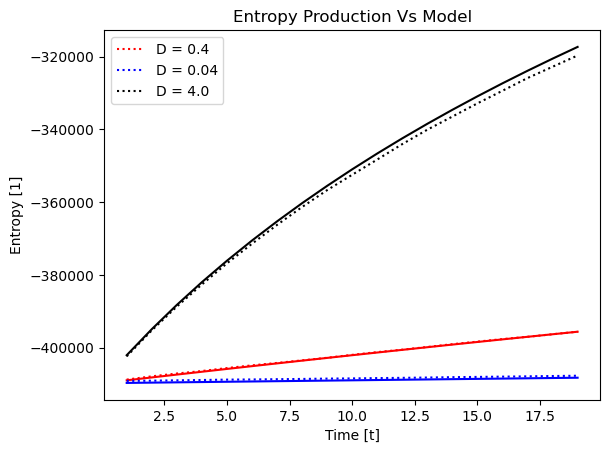

In [37]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']

for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range, entropy[0][1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_Gaussian(var**2, diff_const, t_range,N = N)-2800, color = color)
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.title("Entropy Vs Model")
plt.legend()
plt.show()

In [62]:
diff_consts = []
entropies = []
params["gamma_shape"] = 0.2
sim_params["xdomain"] = 1000

for mu in [0.1, 1 , 10]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropy_change, entropy, entropy_normal = entropy_simulation(params, sim_params,to_plot = False)
    entropies.append([entropy, entropy_normal])

<Figure size 640x480 with 0 Axes>

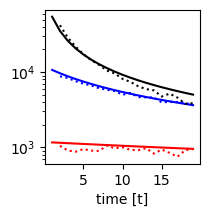

In [79]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

var = sim_params["initial_var_n"]
colors = ['r', 'b', 'k']
plt.figure(figsize= [2, 2])
for diff_const, entropy, color in zip(diff_consts, entropies, colors):

    plt.plot(t_range[1:], np.abs(entropy[0][1:]-entropy[0][:-1])[1:], label = f"D = {diff_const}",linestyle = "dotted", color = color, linewidth = 1.5)
    # plt.plot(t_range, entropy[1][1:],linestyle = "--", linewidth = 1.5)
    plt.plot(t_range, compute_entropy_production_Gaussian(var**2, diff_const, t_range,N = N)-25, color = color)

plt.yscale("log")
plt.xlabel("time [t]")
# plt.legend()
plt.show()

(-54.95, 53.95, -197.75, 4152.75)

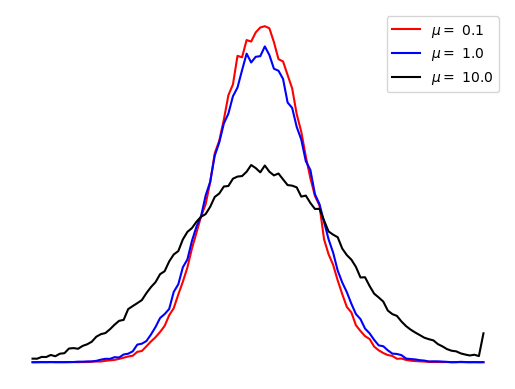

In [87]:
xdomain = 50
sim_params["xdomain"] = xdomain
xspace = np.arange(-xdomain, xdomain, 1)
n = init_guassian(params["N0"], sim_params, "n")
colors = ['r', 'b', 'k']
params["gamma_shape"] = 20

flat_n = np.array(np.sum(n.todense(), axis=0)).squeeze()
# plt.plot(xspace, flat_n, label = "original dist")
for mu, color in zip([1, 10 , 100], colors):
    params["mu"] = mu
    n_new = mutation(n, params, sim_params)
    flat_n_new = np.array(np.sum(n_new.todense(), axis=0)).squeeze()
    plt.plot(xspace, flat_n_new, label=r"$\mu =$" + f" {mu/10}", color = color)
plt.legend()
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('off')  #

In [ ]:
variances = []
entropies = []
diff_consts = []
params["gamma_shape"]= 1
sim_params["initial_var_n"] = 10

for mu in [0.1, 1 , 10]:
    params["mu"] = mu
    diff_const = calc_diff_const(params, sim_params)
    diff_consts.append(diff_const)
    entropies.append(entropy_simulation(params, sim_params, to_plot = True))

In [48]:
%run ../Scripts/entropy.py

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


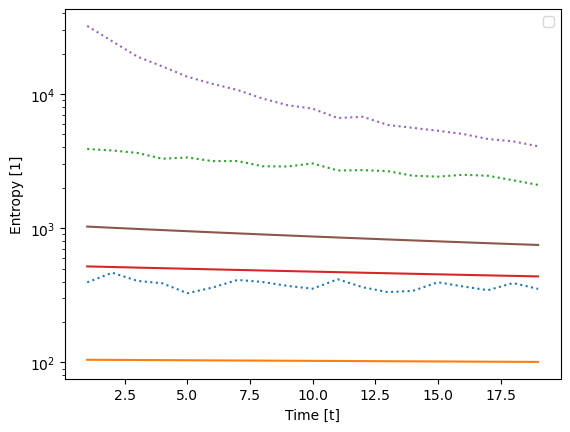

In [61]:
plt.figure()
t = 20
t_range = np.arange(1, t)
N = params["N0"]

for diff_const, entropy_change in zip(diff_consts, entropies):
    plt.plot(t_range, entropy_change[0][1:],linestyle = "dotted", linewidth = 1.5)
    plt.plot(t_range, N*compute_entropy_production_Gaussian(100, 10*diff_const,t_range, dim = 1))
plt.ylabel("Entropy [1]")
plt.xlabel("Time [t]")
plt.legend()
plt.yscale("log")
plt.show()

In [64]:
from fitness import virus_growth


xdomain = 50
sim_params["xdomain"] = xdomain
sim_params["initial_var_n"] = 20
xspace = np.arange(-xdomain, xdomain, 1)
n = init_guassian(params["N0"], sim_params, "n")
flat_n = np.array(np.sum(n.todense(), axis=0))

In [96]:
s1 = 0.1
f = np.zeros_like(xspace)
f = s1*xspace
flat_n_new = flat_n + f*flat_n

flat_n_new_plot = np.clip(np.array(flat_n_new).squeeze(), 0, np.inf)

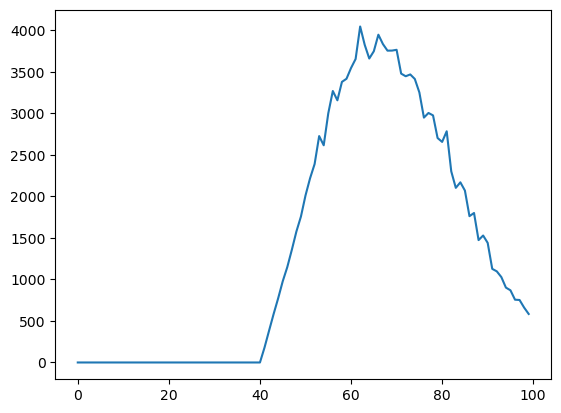

In [97]:
plt.plot(flat_n_new_plot)

In [98]:
s2 = 0.05
f = s2*xspace
flat_n_new2 = flat_n + f*flat_n
flat_n_new_plot2 = np.clip(np.array(flat_n_new2).squeeze(), 0, np.inf)

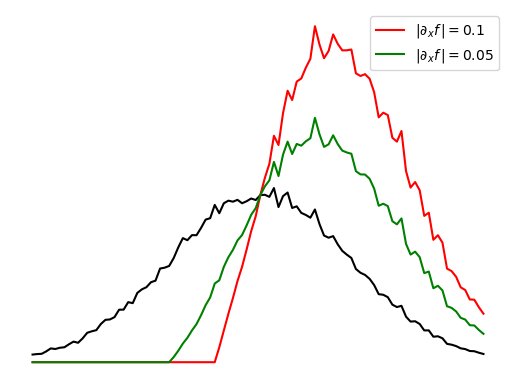

In [100]:
plt.plot(xspace, (flat_n).squeeze(), color = "black")
# plt.plot(xspace, 1*xspace, color = "green", linestyle = "dashed")
plt.plot(xspace, flat_n_new_plot, color = "red", label = r"$|\partial_x f\,| = $" + f"{s1}")
plt.plot(xspace, flat_n_new_plot2, color = "green", label = r"$|\partial_x f\,| = $" + f"{s2}")

plt.legend()
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.axis('off') 
plt.legend()

In [8]:
%run ../Scripts/entropy.py

In [9]:
from scipy.optimize import curve_fit

def get_std_dev(array):
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

    # Example data
    x = np.linspace(-10, 10, 100)
    y = gaussian(x, 1, 0, 2) + np.random.normal(0, 0.1, x.size)  # Adding some random noise to the Gaussian curve

    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x, y, p0=[1, 0, 1])  # Initial guess for parameters: amplitude=1, mean=0, stddev=1

    # Extract the standard deviation from the fitted parameters
    return popt[2]**2

In [10]:
entropy_change_list = []
entropy_change_err_list = []
count_list = []
s_range = np.power(10., np.arange(-1.6, -1, 0.01))
n_seeds = 1

for s in s_range:
    f[0, :] = s*xspace

    flat_n_new_list = []
    for _ in range(n_seeds):
        flat_n_new = np.clip(flat_n + f*flat_n, 0, np.inf)

        entropy_change = compute_entropy_change(flat_n_new, flat_n, dim = 1)
        flat_n_new_list.append(entropy_change)
    entropy_change_list.append(np.mean(flat_n_new_list))
    entropy_change_err_list.append(np.var(flat_n_new_list))
    count_list.append(np.sum(flat_n_new_plot))

count_list = np.array(count_list)
# entropy_change_list = np.array(entropy_change_list)

In [11]:
s_range

array([0.02511886, 0.02570396, 0.02630268, 0.02691535, 0.02754229,
       0.02818383, 0.02884032, 0.02951209, 0.03019952, 0.03090295,
       0.03162278, 0.03235937, 0.03311311, 0.03388442, 0.03467369,
       0.03548134, 0.03630781, 0.03715352, 0.03801894, 0.03890451,
       0.03981072, 0.04073803, 0.04168694, 0.04265795, 0.04365158,
       0.04466836, 0.04570882, 0.04677351, 0.04786301, 0.04897788,
       0.05011872, 0.05128614, 0.05248075, 0.05370318, 0.05495409,
       0.05623413, 0.05754399, 0.05888437, 0.06025596, 0.0616595 ,
       0.06309573, 0.06456542, 0.06606934, 0.0676083 , 0.0691831 ,
       0.07079458, 0.0724436 , 0.07413102, 0.07585776, 0.07762471,
       0.07943282, 0.08128305, 0.08317638, 0.0851138 , 0.08709636,
       0.08912509, 0.09120108, 0.09332543, 0.09549926, 0.09772372,
       0.1       ])

In [12]:
entropy_change_list

[-1898.0736989924917,
 -2082.0199749171734,
 -2082.0199749171734,
 -2792.7286454377463,
 -3345.9058583782753,
 -3726.040904635098,
 -4358.524336575647,
 -5179.852276166668,
 -5179.852276166668,
 -5874.451975645963,
 -6783.937061375123,
 -7637.721320406883,
 -7637.721320406883,
 -8265.86371428438,
 -8615.902437511482,
 -8615.902437511482,
 -9399.792779476964,
 -10480.367532566073,
 -10480.367532566073,
 -12290.150166111998,
 -12290.150166111998,
 -13800.467632383807,
 -16260.055962806568,
 -17063.700072526583,
 -19090.215770587558,
 -20328.223254378885,
 -23598.39179787191,
 -24917.422988915117,
 -27815.21654236922,
 -29664.53839730518,
 -33745.45205439313,
 -35969.238582766266,
 -35969.238582766266,
 -40703.97435719555,
 -43722.285419264925,
 -47848.25254863477,
 -51420.65075841406,
 -57604.445098499884,
 -57604.445098499884,
 -62459.67637750413,
 -70179.56424852193,
 -76306.51308726054,
 -77403.7727699693,
 -86285.9201419683,
 -93203.15028736962,
 -94585.044122027,
 -104333.4840737901

Text(0.5, 0, '$|\\partial_x f|$')

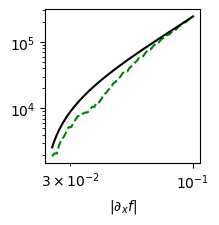

In [23]:
errbars = np.sqrt(np.array(entropy_change_err_list)/n_seeds)
var = get_std_dev(flat_n)
plt.figure(figsize= [2, 2])
plt.plot(s_range, np.abs(entropy_change_list), color = "green", linestyle = "dashed")
# plt.errorbar(s_range, np.abs(entropy_change_list), yerr= errbars)
plt.plot(s_range, 10*np.abs(count_list*(np.log(1-(var*4.2*s_range**2))))-12000, color = "black")
plt.yscale("log")
plt.xscale("log")
plt.xticks([0.1, 0.03], minor=True)
plt.xlabel(r"$|\partial_x f|$")
# plt.yticks([])

In [206]:
1/2*np.log(1-4.48*(0.0001**2))

-2.2400000523276337e-08